In [5]:
from FinancialModelingPrep.tickers import Ticker
from FinancialModelingPrep.indices import Index
import transformers
from transformers import (AutoModel, BertTokenizer,
    BertForSequenceClassification,)
import torch
import torch.nn as nn
import torch.nn.functional as F
from finBERT.finbert import utils
import pandas as pd
import torch.nn.functional as F
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

In [6]:
def get_prediction(text: str, 
    model: AutoModelForSequenceClassification=model, 
    tokenizer=tokenizer) -> np.array:
    """
    Get one prediction.

    Parameters
    ----------
    text: str
        The text to be analyzed.
    model: BertModel
        The model to be used.
    tokenizer: BertTokenizer
        The tokenizer to be used.

    Returns
    -------
    predition: np.array
        An array that includes probabilities for each class.
    """

    tokens = tokenizer.tokenize(text)
    tokens = ["[CLS]"] + tokens + ["[SEP]"]
    token_type_ids = [0] * len(tokens)
    attention_mask = [1] * len(tokens)
    input_ids = tokenizer.convert_tokens_to_ids(tokens)
    padding = [0] * (64 - len(input_ids))
    input_ids += padding
    attention_mask += padding
    token_type_ids += padding

    features = []
    features.append(
        utils.InputFeatures(input_ids=input_ids,
                      token_type_ids=token_type_ids,
                      attention_mask=attention_mask,
                      label_id=None))

    all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
    all_attention_mask = torch.tensor([f.attention_mask for f in features], dtype=torch.long)
    all_token_type_ids = torch.tensor([f.token_type_ids for f in features], dtype=torch.long)

    model.eval()
    logits = model(input_ids=all_input_ids, attention_mask=all_attention_mask, 
        token_type_ids=all_token_type_ids).get('logits')
    prediction = F.softmax(logits,
        dim=logits.shape[0]).detach().numpy()
    return prediction

In [97]:
Ticker.get_historical_price("BABA", start_date="2020-01-01", end_date="2020-12-31")

,open,high,low,close,adjClose,volume,unadjustedVolume,change,changePercent,vwap,label,changeOverTime
date,,,,,,,,,,,,
2020-12-31,237.460007,238.919998,231.026993,232.729996,232.729996,23451800.0,23451800.0,-4.73001,-1.992,234.22566,"December 31, 20",-0.01992
2020-12-30,243.348007,243.389999,234.645004,238.389999,238.389999,44812300.0,44812300.0,-4.95801,-2.037,238.80833,"December 30, 20",-0.02037
2020-12-29,231.759995,239.190002,229.600006,236.259995,236.259995,69715900.0,69715900.0,4.5,1.942,235.01667,"December 29, 20",0.01942
2020-12-28,216.880005,224.990005,215.320007,222.360001,222.360001,73512100.0,73512100.0,5.48,2.527,220.89,"December 28, 20",0.02527
2020-12-24,228.235001,229.899994,211.229996,222.0,222.0,141830000.0,141830000.0,-6.235,-2.732,221.04333,"December 24, 20",-0.02732
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-08,216.600006,220.649994,216.320007,218.0,218.0,11959100.0,11959100.0,1.39999,0.646,218.32333,"January 08, 20",0.00646
2020-01-07,217.639999,218.940002,216.690002,217.630005,217.630005,9388000.0,9388000.0,-0.00999,-0.005,217.75334,"January 07, 20",-0.00005
2020-01-06,214.889999,217.160004,214.089996,216.639999,216.639999,11885500.0,11885500.0,1.75,0.814,215.96333,"January 06, 20",0.00814


In [13]:
import datetime as dt
news = Ticker.get_stock_news("BABA", start_date="2022-01-01")
news.loc[:, "day"] = news.index.get_level_values("publishedDate").to_series().dt.to_period("D").values
news = news.head(50)

In [ ]:
# run inference
# news = news.set_index(["day"]).title.apply(get_prediction).to_frame().reset_index()
# news.loc[:, "positive"] =news.title.apply(lambda x: x[0][0])
# news.loc[:, "negative"] =news.title.apply(lambda x: x[0][1])
# news.loc[:, "neutral"] =news.title.apply(lambda x: x[0][2])
# summary = news.groupby("day").mean()
# summary.loc[:, "news_count"] = news.groupby("day").count().negative.values

In [15]:
title_sent = news.set_index(["day"]).title.apply(
        get_prediction).to_frame().reset_index()
content_sent = news.set_index(["day"]).text.apply(
        get_prediction).to_frame().reset_index()
columns = pd.MultiIndex.from_tuples(
    list(itertools.product(["title_sentiment", "content_sentiment"],
        ["positive", "negative", "neutral"])) + [("news_count", "count")])
summary = pd.DataFrame(columns=columns, 
    index=title_sent.groupby("day").mean().index)
news.loc[:, ('title_sentiment', 'positive')] = \
    title_sent.apply(lambda x: x[0][0])
news.loc[:, ('title_sentiment', 'negative')] = \
    title_sent.apply(lambda x: x[0][1])
news.loc[:, ('title_sentiment', 'neutral')] = \
    title_sent.apply(lambda x: x[0][2])
news.loc[:, ('content_sentiment', 'positive')] = \
    content_sent.apply(lambda x: x[0][0])
news.loc[:, ('content_sentiment', 'negative')] = \
    content_sent.apply(lambda x: x[0][1])
news.loc[:, ('content_sentiment', 'neutral')] = \
    content_sent.apply(lambda x: x[0][2])

TypeError: 'Period' object is not subscriptable

In [2]:
import itertools
import pandas as pd
pd.MultiIndex.from_tuples(
        itertools.product(["title_sentiment", "content_sentiment"],
            ["positive", "negative", "neutral"]))

MultiIndex([(  'title_sentiment', 'positive'),
            (  'title_sentiment', 'negative'),
            (  'title_sentiment',  'neutral'),
            ('content_sentiment', 'positive'),
            ('content_sentiment', 'negative'),
            ('content_sentiment',  'neutral')],
           )

/var/folders/nv/5lrdv19x6516010dtwg9ny440000gn/T/ipykernel_5048/2611975810.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


[Text(0, 0.5, 'avg softmax'), Text(0.5, 1.0, 'AAPL sentiment')]

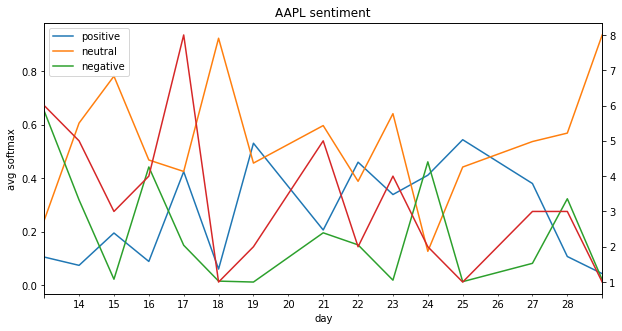

In [111]:
import matplotlib.pyplot as plt
f, ax = plt.subplots(1, figsize=(10,5))
summary.loc[:, ["positive", "neutral", "negative"]].plot(ax=ax)
summary.news_count.plot(ax=ax, secondary_y=True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set(ylabel="avg softmax",
    title="AAPL sentiment")

In [112]:
summary

,positive,negative,neutral,news_count
day,,,,
2022-06-13,0.105999,0.650957,0.243044,6
2022-06-14,0.075064,0.318872,0.606064,5
2022-06-15,0.195712,0.023269,0.781018,3
2022-06-16,0.089627,0.442186,0.468187,4
2022-06-17,0.424592,0.149998,0.425410,8
2022-06-18,0.061260,0.016234,0.922506,1
2022-06-19,0.530683,0.012744,0.456573,2
2022-06-21,0.206960,0.196440,0.596600,5
2022-06-22,0.459969,0.151454,0.388577,2
